# CUPED方法实现
1. generate_base_variant2 生成实验组和对照组的Y和X，实验组=对照组+0.05
2. cuped 实现指标校正
3. cuped_mean 均值填充
4. cuped_zero 0填充
5. cuped_exist 是否存在实验前数据（0/1）作为协变量

In [1]:
from numpy.random import multivariate_normal
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def cuped(metric, covariate):
    '''
    使用CUPED矫正，得到新的指标 Ycv = Y - (X - X_mean) * theta
    metric: 原始指标Y
    covariate: 协变量X
    return: 新指标Ycv
    '''
    covariate_mean = np.mean(covariate) #协变量X的均值
    covxy = np.cov(metric, covariate) #指标Y和协变量X的协方差
    cov_xy = covxy[0][1]
    varx = np.var(covariate) #协变量X的方差
    theta = cov_xy / varx #最小化var(Ycv)时theta的取值
    
    n = len(metric)
    metric_cuped = [0] * n #新的指标Ycv
    for i in range(n):
        if covariate[i] is None:
            metric_cuped[i] = metric[i]
        else:
            metric_cuped[i] = metric[i] - (covariate[i] - covariate_mean) * theta
    return metric_cuped

In [3]:
def generate_base_variant(var1, var2, cov, n):
    '''
    生成对照组和实验组的指标、协变量
    '''
    cov_matrix = [[var1, cov],
                 [cov, var2]]
    data_base = multivariate_normal([0,0], cov_matrix, size=n)
    data_variant = multivariate_normal([0,0], cov_matrix, size=n)
    
    metric_base = data_base[:, 0]
    covariate_base = data_base[:, 1]
    metric_variant = data_variant[:, 0]
    covariate_variant = data_variant[:, 1]
    
    return metric_base, covariate_base, metric_variant, covariate_variant

Text(0, 0.5, 'p-value')

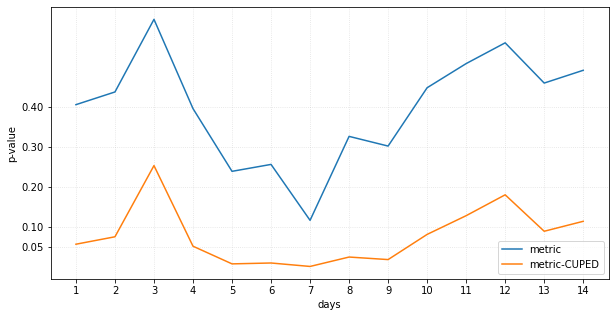

In [4]:
metric_base, covariate_base, metric_variant, covariate_variant = generate_base_variant(1, 1, 0.9, 140000)
y1 = []
y2 = []

for i in range(10000, 150000, 10000):
    y_base = metric_base[:i]
    x_base = covariate_base[:i]
    y_variant = metric_variant[:i]
    x_variant = covariate_variant[:i]
    
    y_base_cuped = cuped(y_base, x_base)
    y_variant_cuped = cuped(y_variant, x_variant)
    
    _, p1 = stats.ttest_ind(y_base, y_variant)
    _, p2 = stats.ttest_ind(y_base_cuped, y_variant_cuped)
    
    y1.append(p1)
    y2.append(p2)
    
x = list(range(1, len(y1)+1))
plt.figure(figsize=[10,5])
plt.plot(x, y1, label="metric")
plt.plot(x, y2, label="metric-CUPED")
plt.xticks(x)
plt.yticks([0.05, 0.1, 0.2, 0.3, 0.4])
plt.grid(alpha=0.4,linestyle=':')
plt.legend()
plt.xlabel("days")
plt.ylabel("p-value")

In [28]:
def cuped2(metric, covariate):
    '''
    新用户，无实验前数据，协变量用均值填充
    '''
    n = len(metric)
    
    sum_covariate = 0
    cnt = 0
    for i in covariate:
        if i is not None:
            sum_covariate += i
            cnt += 1
    covariate_mean = sum_covariate / cnt
    for i in range(n):
        if covariate[i] is None:
            covariate[i] = covariate_mean
    
    covariate_mean = np.mean(covariate) #协变量X的均值
    covxy = np.cov(metric, covariate) #指标Y和协变量X的协方差
    cov_xy = covxy[0][1]
    varx = np.var(covariate) #协变量X的方差
    theta = cov_xy / varx #最小化var(Ycv)时theta的取值
    
    n = len(metric)
    metric_cuped = [0] * n #新的指标Ycv
    for i in range(n):
        metric_cuped[i] = metric[i] - (covariate[i] - covariate_mean) * theta
    return metric_cuped

Text(0, 0.5, 'p-value')

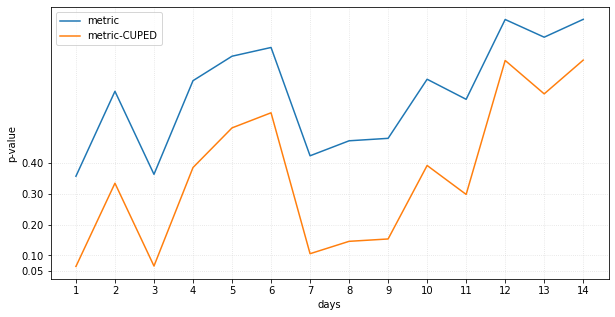

In [148]:
metric_base, covariate_base, metric_variant, covariate_variant = generate_base_variant(1, 1, 0.9, 140000)
a = np.random.randint(140000, size=10000)
for i in a:
    covariate_base[i] = np.nan
    covariate_variant[i] = np.nan
    
y1 = []
y2 = []

for i in range(10000, 150000, 10000):
    y_base = metric_base[:i]
    x_base = covariate_base[:i]
    y_variant = metric_variant[:i]
    x_variant = covariate_variant[:i]
    
    y_base_cuped = cuped3(y_base, x_base)
    y_variant_cuped = cuped3(y_variant, x_variant)
    
    _, p1 = stats.ttest_ind(y_base, y_variant)
    _, p2 = stats.ttest_ind(y_base_cuped, y_variant_cuped)
    
    y1.append(p1)
    y2.append(p2)
    
x = list(range(1, len(y1)+1))
plt.figure(figsize=[10,5])
plt.plot(x, y1, label="metric")
plt.plot(x, y2, label="metric-CUPED")
plt.xticks(x)
plt.yticks([0.05, 0.1, 0.2, 0.3, 0.4])
plt.grid(alpha=0.4,linestyle=':')
plt.legend()
plt.xlabel("days")
plt.ylabel("p-value")

In [176]:
def cuped2(metric, covariate):
    '''
    新用户，无实验前数据，协变量用均值填充
    '''
    n = len(metric)
    
    sum_covariate = 0
    cnt = 0
    for i in covariate:
        if np.isnan(i) == False:
            sum_covariate += i
            cnt += 1
    covariate_mean = sum_covariate / cnt
    for i in range(n):
        if np.isnan(covariate[i]):
            covariate[i] = covariate_mean
    
    covariate_mean = np.mean(covariate) #协变量X的均值
    covxy = np.cov(metric, covariate) #指标Y和协变量X的协方差
    cov_xy = covxy[0][1]
    varx = np.var(covariate) #协变量X的方差
    theta = cov_xy / varx #最小化var(Ycv)时theta的取值
    
    n = len(metric)
    metric_cuped = [0] * n #新的指标Ycv
    for i in range(n):
        metric_cuped[i] = metric[i] - (covariate[i] - covariate_mean) * theta
    return metric_cuped

In [177]:
def cuped3(metric, covariate):
    '''
    协变量用0填充
    '''
    n = len(metric)
    for i in range(n):
        if np.isnan(covariate[i]):
            covariate[i] = 0
    
    covariate_mean = np.mean(covariate) #协变量X的均值
    covxy = np.cov(metric, covariate) #指标Y和协变量X的协方差
    cov_xy = covxy[0][1]
    varx = np.var(covariate) #协变量X的方差
    theta = cov_xy / varx #最小化var(Ycv)时theta的取值
    
    n = len(metric)
    metric_cuped = [0] * n #新的指标Ycv
    for i in range(n):
        metric_cuped[i] = metric[i] - (covariate[i] - covariate_mean) * theta
    return metric_cuped

In [178]:
metric_base, covariate_base, metric_variant, covariate_variant = generate_base_variant(1, 1, 0.9, 140000)
a = np.random.randint(140000, size=10000)
for i in a:
    covariate_base[i] = np.nan
    covariate_variant[i] = np.nan
    
metric_variant_cuped = cuped2(metric_variant, covariate_variant)
d1 = np.var(metric_variant)
d2 = np.var(metric_variant_cuped)
reduction = (d1 - d2) / d1

In [179]:
reduction

0.755560948526523

In [180]:
metric_variant_cuped = cuped3(metric_variant, covariate_variant)
d1 = np.var(metric_variant)
d2 = np.var(metric_variant_cuped)
reduction = (d1 - d2) / d1
reduction

0.755560948526523

In [222]:
metric_base, covariate_base, metric_variant, covariate_variant = generate_base_variant(1, 1, 0.9, 10000)
a = np.random.randint(10000, size=9000)
for i in a:
    covariate_base[i] = np.nan
    covariate_variant[i] = np.nan

In [223]:
var1 = np.var(metric_base)

metric_base_cuped_mean = cuped_mean(metric_base, covariate_base)
metric_base_cuped_zero = cuped_zero(metric_base, covariate_base)

var2 = np.var(metric_base_cuped_mean)
var3 = np.var(metric_base_cuped_zero)

d1 = var1 - var2
d2 = var1 - var3

r1 = d1 / var1
r2 = d2 / var1

In [224]:
r1

0.3315352396749534

In [225]:
r2

0.33147742647523015

In [202]:
var1

1.0023396866666727

In [200]:
var2

0.19200774469149146

In [201]:
var3

0.1920068901037889

In [196]:
def cuped_mean(metric, covariate):
    '''
    新用户，无实验前数据，协变量用均值填充
    '''
    m = covariate.copy()
    n = len(metric)
    sum_covariate = 0
    cnt = 0
    for i in m:
        if np.isnan(i) == False:
            sum_covariate += i
            cnt += 1
    covariate_mean = sum_covariate / cnt
    for i in range(n):
        if np.isnan(m[i]):
            m[i] = covariate_mean
    
    covariate_mean = np.mean(m) #协变量X的均值
    covxy = np.cov(metric, m) #指标Y和协变量X的协方差
    cov_xy = covxy[0][1]
    varx = np.var(m) #协变量X的方差
    theta = cov_xy / varx #最小化var(Ycv)时theta的取值
    
    metric_cuped = [0] * n #新的指标Ycv
    for i in range(n):
        metric_cuped[i] = metric[i] - (m[i] - covariate_mean) * theta
    return metric_cuped

In [197]:
def cuped_zero(metric, covariate):
    '''
    新用户，无实验前数据，协变量用0填充
    '''
    m = covariate.copy()
    n = len(metric)
    for i in range(n):
        if np.isnan(m[i]):
            m[i] = 0
    
    covariate_mean = np.mean(m) #协变量X的均值
    covxy = np.cov(metric, m) #指标Y和协变量X的协方差
    cov_xy = covxy[0][1]
    varx = np.var(m) #协变量X的方差
    theta = cov_xy / varx #最小化var(Ycv)时theta的取值
    
    metric_cuped = [0] * n #新的指标Ycv
    for i in range(n):
        metric_cuped[i] = metric[i] - (m[i] - covariate_mean) * theta
    return metric_cuped

In [250]:
def cuped_exist(metric, covariate):
    '''
    新用户，无实验前数据，使用是否存在实验前数据作为协变量
    '''
    n = len(metric)
    a = [0] * n
    for i in range(n):
        if np.isnan(covariate[i]) == False:
            a[i] = 1
    
    covariate_mean = np.mean(a) #协变量X的均值
    covxy = np.cov(metric, a) #指标Y和协变量X的协方差
    cov_xy = covxy[0][1]
    varx = np.var(a) #协变量X的方差
    theta = cov_xy / varx #最小化var(Ycv)时theta的取值
    
    metric_cuped = [0] * n #新的指标Ycv
    for i in range(n):
        metric_cuped[i] = metric[i] - (a[i] - covariate_mean) * theta
    return metric_cuped

In [256]:
metric_base, covariate_base, metric_variant, covariate_variant = generate_base_variant(1, 1, 0.9, 10000)
a = np.random.randint(10000, size=9000)
for i in a:
    covariate_base[i] = np.nan
    covariate_variant[i] = np.nan
    
var1 = np.var(metric_base)

metric_base_cuped_exist = cuped_exist(metric_base, covariate_base)

var2 = np.var(metric_base_cuped_exist)

d1 = var1 - var2
r1 = d1 / var1
r1

0.00010955879805943348

In [264]:
x = np.arange(6)
y1 = [0.8084, 0.7365, 0.6714, 0.4889, 0.4059, 0.3315]
y2 = [0.8084, 0.7365, 0.6714, 0.4889, 0.40592, 0.3314]
y3 = [0.002, 0.005, 0.01, 0.005, 0.001, 0.01]

Text(0.5, 0, 'Missing Rate of Covariate')

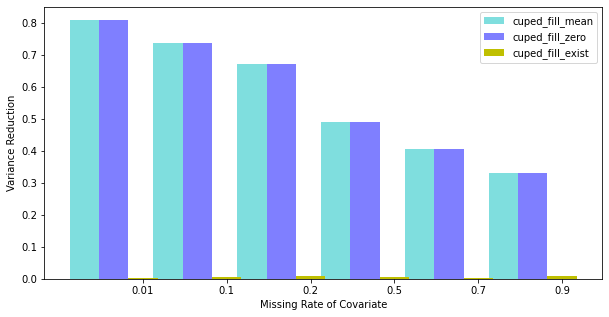

In [266]:
bar_width = 0.35

plt.figure(figsize=[10,5])
plt.bar(x, y1, bar_width, color="c", align="center", tick_label=["0.01", "0.1", "0.2", "0.5", "0.7", "0.9"], label="cuped_fill_mean",alpha=0.5)
plt.bar(x+bar_width, y2, bar_width, color="b", align="center", tick_label = ["0.01", "0.1", "0.2", "0.5", "0.7", "0.9"], label="cuped_fill_zero",alpha=0.5)
plt.bar(x+bar_width*2, y3, bar_width, color='y', align='center', tick_label = ["0.01", "0.1", "0.2", "0.5", "0.7", "0.9"], label="cuped_fill_exist")
plt.legend()
plt.ylabel("Variance Reduction")
plt.xlabel("Missing Rate of Covariate")

In [353]:
def generate_base_variant2(var1, var2, cov, n):
    '''
    生成对照组和实验组的指标、协变量
    '''
    cov_matrix = [[var1, cov],
                 [cov, var2]]
    data_base = multivariate_normal([0,0], cov_matrix, size=n)
    
    metric_base = data_base[:n//2, 0]
    covariate_base = data_base[:n//2, 1]
    metric_variant = data_base[n//2:, 0]
    metric_variant = metric_variant - 0.001
    covariate_variant = data_base[n//2:, 1]
    
    return metric_base, covariate_base, metric_variant, covariate_variant

Text(0, 0.5, 'p-value')

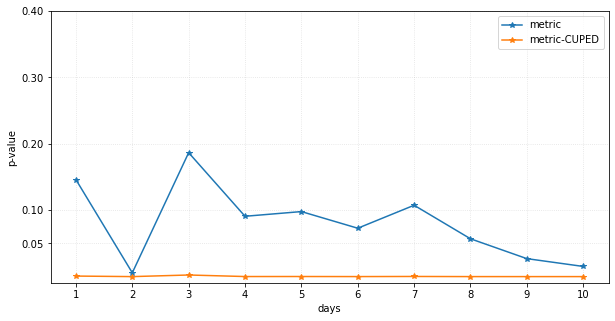

In [355]:
metric_base, covariate_base, metric_variant, covariate_variant = generate_base_variant2(1, 1, 0.9, 2000000)
y1 = []
y2 = []

for i in range(10000, 110000, 10000):
    y_base = metric_base[:i]
    x_base = covariate_base[:i]
    y_variant = metric_variant[:i]
    x_variant = covariate_variant[:i]
    
    y_base_cuped = cuped(y_base, x_base)
    y_variant_cuped = cuped(y_variant, x_variant)
    
    _, p1 = stats.ttest_ind(y_base, y_variant)
    _, p2 = stats.ttest_ind(y_base_cuped, y_variant_cuped)
    
    y1.append(p1)
    y2.append(p2)

x = list(range(1, len(y1)+1))
plt.figure(figsize=[10,5])
plt.plot(x, y1, '-*', label="metric")
plt.plot(x, y2, '-*', label="metric-CUPED")
plt.xticks(x)
plt.yticks([0.05, 0.1, 0.2, 0.3, 0.4])
plt.grid(alpha=0.4,linestyle=':')
plt.legend()
plt.xlabel("days")
plt.ylabel("p-value")